In [7]:
import mne
raw = mne.io.read_raw_eeglab('./sub-NDARDB033FW5_task-RestingState_eeg.set', preload=True)
raw

# Print events from the raw object
events = mne.events_from_annotations(raw)
print("\nEvents found:")
print(events)

# Print annotations
print("\nAnnotations:")
print(raw.annotations)

# You can also get more detailed information about the annotations
print("\nAnnotation details:")
for ann in raw.annotations:
    print(f"Onset: {ann['onset']:.2f}s, Duration: {ann['duration']:.2f}s, Description: {ann['description']}")

Used Annotations descriptions: ['boundary', 'break cnt', 'instructed_toCloseEyes', 'instructed_toOpenEyes', 'resting_start']

Events found:
(array([[     0,      0,      2],
       [   957,      0,      5],
       [ 29108,      0,      4],
       [ 39108,      0,      3],
       [ 59103,      0,      4],
       [ 69103,      0,      3],
       [ 89104,      0,      4],
       [ 99105,      0,      3],
       [119105,      0,      4],
       [129106,      0,      3],
       [149106,      0,      4],
       [159107,      0,      3],
       [179107,      0,      4],
       [181388,      0,      1]]), {'boundary': 1, 'break cnt': 2, 'instructed_toCloseEyes': 3, 'instructed_toOpenEyes': 4, 'resting_start': 5})

Annotations:
<Annotations | 14 segments: boundary (1), break cnt (1), ...>

Annotation details:
Onset: 0.00s, Duration: 0.00s, Description: break cnt
Onset: 1.91s, Duration: 0.00s, Description: resting_start
Onset: 58.22s, Duration: 0.00s, Description: instructed_toOpenEyes
Onset: 78

/var/folders/3j/r_x6gj790wvcx_mh157ctypm0000gn/T/ipykernel_40246/943693508.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab('./sub-NDARDB033FW5_task-RestingState_eeg.set', preload=True)


In [18]:
# Extract segments after "instructed_toCloseEyes" events
import numpy as np

# Get all "instructed_toCloseEyes" events from raw annotations
close_eyes_events = []
for annot in raw.annotations:
    if annot['description'] == 'instructed_toCloseEyes':
        close_eyes_events.append(annot['onset'])

# Define segment parameters
post_event_delay = 5  # seconds after event
sfreq = raw.info['sfreq']  # sampling frequency

# Extract segments
segments = []
for event_time in close_eyes_events:
    for event_add_time in range(0, 34, 2): # every 2 seconds for 34 seconds
        start_sample = int((event_time + post_event_delay + event_add_time) * sfreq)
        end_sample = start_sample + int(2 * sfreq)
    
        # Check if segment extends beyond data
        if end_sample <= raw.n_times:
            segment = raw.get_data(start=start_sample, stop=end_sample)
            segments.append(segment)

segments = np.array(segments)  # Shape will be (n_segments, n_channels, n_samples)

print(f"Found {len(close_eyes_events)} 'instructed_toCloseEyes' events")
print(f"Extracted {len(segments)} segments of {segment_duration} seconds each")
print(f"Segment shape: {segments.shape}")

Found 5 'instructed_toCloseEyes' events
Extracted 85 segments of 34 seconds each
Segment shape: (85, 129, 1000)


In [ ]:
# Extract 2-second segments after "instructed_toCloseEyes" events
import mne
raw = mne.io.read_raw_eeglab('./sub-NDARDB033FW5_task-RestingState_eeg.set', preload=True)

# Create events array from annotations
events, event_id = mne.events_from_annotations(raw)

# Create new events array for 2-second segments
new_events = []
sfreq = raw.info['sfreq']
for event in events[events[:, 2] == event_id['instructed_toCloseEyes']]:
    # For each original event, create events every 2 seconds from 5s to 39s after
    start_times = event[0] + np.arange(15, 29, 2) * sfreq
    new_events.extend([[int(t), 0, 1] for t in start_times])

for event in events[events[:, 2] == event_id['instructed_toOpenEyes']]:
    # For each original event, create events every 2 seconds from 5s to 39s after
    start_times = event[0] + np.arange(5, 19, 2) * sfreq
    new_events.extend([[int(t), 0, 2] for t in start_times])

# replace events in raw
new_events = np.array(new_events)
annot_from_events = mne.annotations_from_events(
    events=new_events,
    event_desc={1: 'eyes_closed', 2: 'eyes_open'},
    sfreq=raw.info['sfreq']
)

# Clear existing annotations and set new ones
raw.set_annotations(annot_from_events)
# Create Epochs object with 2-second segments
epochs = mne.Epochs(raw,
                   event_id={'eyes_closed': 1, 'eyes_open': 2},
                   tmin=0,
                   tmax=1.998,
                   baseline=None,
                   preload=True)

print(f"Number of 2-second segments: {len(epochs)}")
print(f"Data shape: {epochs.get_data().shape}")


Used Annotations descriptions: ['boundary', 'break cnt', 'instructed_toCloseEyes', 'instructed_toOpenEyes', 'resting_start']
Used Annotations descriptions: ['eyes_closed', 'eyes_open']
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 70 events and 1000 original time points ...
0 bad epochs dropped
Number of 2-second segments: 70
Data shape: (70, 129, 1000)
<Annotations | 70 segments: eyes_closed (35), eyes_open (35)>


/var/folders/3j/r_x6gj790wvcx_mh157ctypm0000gn/T/ipykernel_82384/2678803217.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab('./sub-NDARDB033FW5_task-RestingState_eeg.set', preload=True)
/var/folders/3j/r_x6gj790wvcx_mh157ctypm0000gn/T/ipykernel_82384/2678803217.py:30: RuntimeWarning: Omitted 7 annotation(s) that were outside data range.
  raw.set_annotations(annot_from_events)


In [9]:
from braindecode.preprocessing import Preprocessor
import numpy as np
import mne

class hbn_ec_ec_reanotation(Preprocessor):
    def __init__(self):
        pass    
    
    def apply(self, raw):
        # Create events array from annotations
        events, event_id = mne.events_from_annotations(raw)

        # Create new events array for 2-second segments
        new_events = []
        sfreq = raw.info['sfreq']
        for event in events[events[:, 2] == event_id['instructed_toCloseEyes']]:
            # For each original event, create events every 2 seconds from 15s to 29s after
            start_times = event[0] + np.arange(15, 29, 2) * sfreq
            new_events.extend([[int(t), 0, 1] for t in start_times])

        for event in events[events[:, 2] == event_id['instructed_toOpenEyes']]:
            # For each original event, create events every 2 seconds from 5s to 19s after
            start_times = event[0] + np.arange(5, 19, 2) * sfreq
            new_events.extend([[int(t), 0, 2] for t in start_times])

        # replace events in raw
        new_events = np.array(new_events)
        annot_from_events = mne.annotations_from_events(events=new_events,event_desc={1: 'eyes_closed', 2: 'eyes_open'},sfreq=raw.info['sfreq'])
        raw.set_annotations(annot_from_events)        
        return raw

# Example usage:
processor = hbn_ec_ec_reanotation()
raw = mne.io.read_raw_eeglab('./sub-NDARDB033FW5_task-RestingState_eeg.set', preload=True)
raw2 = processor.apply(raw)

events = mne.events_from_annotations(raw)
print("\nEvents found:")
print(events)


Used Annotations descriptions: ['boundary', 'break cnt', 'instructed_toCloseEyes', 'instructed_toOpenEyes', 'resting_start']
Used Annotations descriptions: ['eyes_closed', 'eyes_open']

Events found:
(array([[ 31608,      0,      2],
       [ 32608,      0,      2],
       [ 33608,      0,      2],
       [ 34608,      0,      2],
       [ 35608,      0,      2],
       [ 36608,      0,      2],
       [ 37608,      0,      2],
       [ 46608,      0,      1],
       [ 47608,      0,      1],
       [ 48608,      0,      1],
       [ 49608,      0,      1],
       [ 50608,      0,      1],
       [ 51608,      0,      1],
       [ 52608,      0,      1],
       [ 61603,      0,      2],
       [ 62603,      0,      2],
       [ 63603,      0,      2],
       [ 64603,      0,      2],
       [ 65603,      0,      2],
       [ 66603,      0,      2],
       [ 67603,      0,      2],
       [ 76603,      0,      1],
       [ 77603,      0,      1],
       [ 78603,      0,      1],
       

/var/folders/3j/r_x6gj790wvcx_mh157ctypm0000gn/T/ipykernel_82384/1675062375.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab('./sub-NDARDB033FW5_task-RestingState_eeg.set', preload=True)
/var/folders/3j/r_x6gj790wvcx_mh157ctypm0000gn/T/ipykernel_82384/1675062375.py:29: RuntimeWarning: Omitted 7 annotation(s) that were outside data range.
  raw.set_annotations(annot_from_events)


In [25]:
new_events


[[46608, 0, 1],
 [47608, 0, 1],
 [48608, 0, 1],
 [49608, 0, 1],
 [50608, 0, 1],
 [51608, 0, 1],
 [52608, 0, 1],
 [76603, 0, 1],
 [77603, 0, 1],
 [78603, 0, 1],
 [79603, 0, 1],
 [80603, 0, 1],
 [81603, 0, 1],
 [82603, 0, 1],
 [106605, 0, 1],
 [107605, 0, 1],
 [108605, 0, 1],
 [109605, 0, 1],
 [110605, 0, 1],
 [111605, 0, 1],
 [112605, 0, 1],
 [136606, 0, 1],
 [137606, 0, 1],
 [138606, 0, 1],
 [139606, 0, 1],
 [140606, 0, 1],
 [141606, 0, 1],
 [142606, 0, 1],
 [166607, 0, 1],
 [167607, 0, 1],
 [168607, 0, 1],
 [169607, 0, 1],
 [170607, 0, 1],
 [171607, 0, 1],
 [172607, 0, 1],
 [31608, 0, 2],
 [32608, 0, 2],
 [33608, 0, 2],
 [34608, 0, 2],
 [35608, 0, 2],
 [36608, 0, 2],
 [37608, 0, 2],
 [61603, 0, 2],
 [62603, 0, 2],
 [63603, 0, 2],
 [64603, 0, 2],
 [65603, 0, 2],
 [66603, 0, 2],
 [67603, 0, 2],
 [91604, 0, 2],
 [92604, 0, 2],
 [93604, 0, 2],
 [94604, 0, 2],
 [95604, 0, 2],
 [96604, 0, 2],
 [97604, 0, 2],
 [121605, 0, 2],
 [122605, 0, 2],
 [123605, 0, 2],
 [124605, 0, 2],
 [125605, 0, 2]

In [17]:
a = range(0,10, 2)
a[3]

6

In [1]:
# USE PYTHON ASR
import mne

sample_data_path = mne.datasets.sample.data_path()
eeg_file = str(sample_data_path) + '/MEG/sample/sample_audvis_raw.fif'

# Read the raw EEG data
raw = mne.io.read_raw_fif(eeg_file, preload=True)
print(raw.info)

import asrpy
asr = asrpy.ASR(sfreq=raw.info["sfreq"], cutoff=20)
asr.fit(raw)
raw = asr.transform(raw)

Opening raw data file /Users/arno/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle


/Users/arno/miniconda3/envs/p311env/lib/python3.11/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
<Info | 21 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off
 sfreq: 600.6 Hz
>


In [1]:
import sys
import importlib
sys.path.insert(0, '/Users/arno/Python/eegprep/src/')
import eegprep
importlib.reload(eegprep)  # Step 3: Reload the library to reflect the changes
from eegprep import pop_loadset
from eegprep import iclabel

# Load the dataset
eeg_file = '../data/eeglab_data_with_ica_tmp.set'
EEG = pop_loadset(eeg_file)
# EEG = pop_eegfiltnew(EEG, locutoff=5,hicutoff=25,revfilt=True,plotfreqz=False)
# EEG = clean_artifacts(EEG, FlatlineCriterion=5,ChannelCriterion=0.87, LineNoiseCriterion=4,Highpass=[0.25, 0.75],BurstCriterion= 20, WindowCriterion=0.25, BurstRejection=True, WindowCriterionTolerances=[float('-inf'), 7])
EEG = iclabel(EEG)
# pop_saveset(EEG, fname_out)

In [5]:
from oct2py import octave as eeglab
sys.path.insert(0, '/Users/arno/Python/eegprep/src/')
import eegprep
importlib.reload(eegprep)  # Step 3: Reload the library to reflect the changes
from eegprep import pop_loadset
from eegprep import eeglabcompat
import time

path2eeglab = '/System/Volumes/Data/data/matlab/eeglab/'
eeglab.addpath(path2eeglab + '/functions/guifunc')
eeglab.addpath(path2eeglab + '/functions/popfunc')
eeglab.addpath(path2eeglab + '/functions/adminfunc')
eeglab.addpath(path2eeglab + '/plugins/firfilt')
eeglab.addpath(path2eeglab + '/functions/sigprocfunc')
eeglab.addpath(path2eeglab + '/functions/miscfunc')
eeglab.addpath(path2eeglab + '/plugins/dipfit')

start = time.time()
EEG = eeglab.pop_loadset(path2eeglab + '/sample_data/eeglab_data_epochs_ica.set')
stop = time.time()
print(f"Time taken pop_loadset: {stop - start}")

# time the function below
import time
start = time.time()
EEG2 = eeglab.pop_resample(EEG, 100)
stop = time.time()
print(f"Time taken pop_resample: {stop - start}")


























pop_loadset(): loading file /System/Volumes/Data/data/matlab/eeglab/sample_data/eeglab_data_epochs_ica.set ...
    eeg_checkset at line 187 column 1
    pop_loadset at line 249 column 9
    _pyeval at line 57 column 30

    eeg_hist at line 53 column 21
    eeg_checkset at line 1295 column 13
    pop_loadset at line 249 column 9
    _pyeval at line 57 column 30

    eeg_checkset at line 187 column 1
    pop_loadset at line 253 column 13
    _pyeval at line 57 column 30

Reading float file '/System/Volumes/Data/data/matlab/eeglab/sample_data/eeglab_data_epochs_ica.fdt'...
eeg_checkset: recomputing the ICA activation matrix ...
Time taken pop_loadset: 3.2334253787994385



Signal Processing Toolbox absent: using custom interpolation instead of resample() function.
This method uses cubic spline interpolation after anti-aliasing (see >> help spline)
resampling data 100.0000 Hz
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
res

In [9]:
import eegprep
importlib.reload(eegprep)  # Step 3: Reload the library to reflect the changes
from eegprep import pop_loadset
from eegprep import pop_eegfiltnew
from eegprep import clean_artifacts

eeglab_file_path = '/System/Volumes/Data/data/matlab/eeglab/sample_data/eeglab_data.set'
EEG = pop_loadset(eeglab_file_path)
EEG = pop_eegfiltnew(EEG, locutoff=5,hicutoff=25,revfilt=True,plotfreqz=False)
EEG = clean_artifacts(EEG, FlatlineCriterion=5,ChannelCriterion=0.87, LineNoiseCriterion=4,Highpass=False,BurstCriterion= 20, WindowCriterion=0.25, BurstRejection=False, WindowCriterionTolerances=[float('-inf'), 7])


Oct2PyError: Value "pop_loadset" does not exist in Octave workspace

In [6]:
import pop_loadset
import importlib
import matplotlib.pyplot as plt
importlib.reload(pop_loadset)  # Step 3: Reload the library to reflect the changes
from pop_loadset import pop_loadset

eeglab_file_path = '/System/Volumes/Data/data/matlab/eeglab/sample_data/eeglab_data_epochs_ica.set'
#eeglab_file_path = 'NDARZZ830JM7_eyesclosed.set'
EEG2 = pop_loadset(eeglab_file_path)

print(EEG2['data'][0,2,1])

# eeglab.eeg_compare(EEG, EEG2)

# print(EEG['filepath'])
# print(EEG2['filepath'])

# Field filepath differs
# Field icaact differs
# Field icawinv differs
# Field icaweights differs
# Field chanlocs differs
# Field urchanlocs differs
# Field chaninfo differs
# Field event differs (n=157 vs n=157)
# Field urevent differs
# Field epoch differs
# Field epochdescription differs
# Field reject differs
# Field history differs
# Field saved differs
# Field etc differs
# Field run missing in second dataset
# Field roi missing in second dataset
# The field above are different between the two datasets
# print them all
# print(EEG.keys())
# print(EEG2.keys())
# for key in EEG.keys():
#     if key in EEG2.keys():
#         if not np.all(EEG[key] == EEG2[key]):
#             print(key)
#     else:
#         print(key)
# for key in EEG2.keys():
#     if key not in EEG.keys():
#         print(key)

# check if EEG exists in the workspace
if 'EEG' in locals():
    print(EEG['filepath'])
    print(EEG2['filepath'])
    print(EEG['icaact'].shape)
    print(EEG2['icaact'].shape)
    print(EEG['icawinv'].shape)
    print(EEG2['icawinv'].shape)
    print(EEG['icaweights'].shape)
    print(EEG2['icaweights'].shape)
    print(EEG['chanlocs'].shape)
    print(EEG2['chanlocs'].shape)
    print(EEG['urchanlocs'].shape)
    print(EEG2['urchanlocs'].shape)

    EEG['chanlocs']['labels'][0,0]

    EEG.event.type[0,0]
    EEG['event']['type'][0,0]
    EEG2['event'][0]['type']

-31.087076


/Users/arno/Python/iclabel/pop_loadset.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([new_check(item) for item in obj])


In [15]:
a = np.array([1, 2, 3])

# check if a is a numpy array
if isinstance(a, np.ndarray):
    print('a is a numpy array')

TypeError: object of type 'int' has no len()

In [63]:
import numpy as np

if len(EEG['icachansind']) == EEG['nbchan']:
    # Subtract mean from EEG data using broadcasting in NumPy
    EEG['data'] = EEG['data'] - np.mean(EEG['data'], axis=0)
    
    # Subtract mean from EEG icawinv using broadcasting in NumPy
    EEG['icawinv'] = EEG['icawinv'] - np.mean(EEG['icawinv'], axis=0)
    
    # Compute the pseudoinverse of EEG['icawinv']
    EEG['icaweights'] = np.linalg.pinv(EEG['icawinv'])
    
    # Create an identity matrix for EEG['icasphere']
    EEG['icasphere'] = np.eye(EEG['nbchan'])
    
    # Set EEG['ref'] to 'average'
    EEG['ref'] = 'average'
    
    # Update the reference for each channel in EEG['chanlocs']
    for iChan in range(len(EEG['chanlocs'])):
        EEG['chanlocs'][iChan]['ref'] = 'average'

In [5]:
# Create the list of dictionaries
d_list = [{'labels': c} for c in ['a','b','c']]

# Define the data type for the structured array
dtype = np.dtype([('labels', np.str_)])

# Convert the list of dictionaries to a structured NumPy array
tmp = np.array([ (item['labels'],) for item in d_list ], dtype=dtype)



('',)

In [2]:
# save_d_to_mat.py

import numpy as np
from scipy.io import savemat

# Create the list of dictionaries
d_list = [{'labels': c} for c in range(2)]

# Define the data type for the structured array
dtype = np.dtype([('labels', np.int32)])

# Convert the list of dictionaries to a structured NumPy array
d_array = np.array([ (item['labels'],) for item in d_list ], dtype=dtype)

# Save the structured array to a MATLAB .mat file
savemat('d_struct2.mat', {'d': d_array})

NameError: name 'pop_loadset' is not defined

In [15]:
from topoplot import topoplot
from pop_loadset import pop_loadset
from pop_saveset import pop_saveset
import os
import time

eeglab_file_path = '/System/Volumes/Data/data/matlab/eeglab/sample_data/eeglab_data_epochs_ica.set'
eeglab_file_path = './eeglab_data_with_ica_tmp.set'
start = time.time()
EEG = pop_loadset(eeglab_file_path)
stop = time.time()
print(f"Time taken pop_loadset(p): {stop - start}")

start = time.time()
EEG = pop_saveset(EEG, 'tmp.set')
stop = time.time()
print(f"Time taken pop_saveset(p): {stop - start}")

# plot data using MNE

import mne
import matplotlib.pyplot as plt

# create MNE info structure
info = mne.create_info(ch_names=[ x['labels'] for x in EEG['chanlocs']], sfreq=EEG['srate'], ch_types='eeg')

# create MNE Raw object
raw = mne.io.RawArray(EEG['data'].transpose(0,2,1).reshape(EEG['nbchan'], -1), info)

# plot data
raw.plot(n_channels=10, scalings=100, title='Data from arrays', show=True, block=True, duration=10.0)    

# plot topoplot
# topoplot(EEG['icawinv'][:, 0], EEG['chanlocs'], show=True)

Time taken pop_loadset(p): 0.03513383865356445
Time taken pop_saveset(p): 0.08228611946105957


/Users/arno/Python/iclabel/pop_loadset.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([new_check(item) for item in obj])


ValueError: axes don't match array

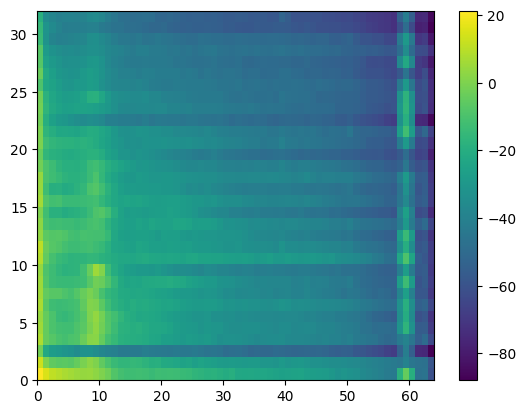

In [173]:
import pop_loadset
import importlib
import matplotlib.pyplot as plt
importlib.reload(pop_loadset)  # Step 3: Reload the library to reflect the changes
from pop_loadset import pop_loadset

EEG = pop_loadset(eeglab_file_path)
EEG['data']

nfreqs = 100
pct_data = 100

# clean input cutoff freq
nyquist = EEG['srate'] // 2
if nfreqs is None or nfreqs > nyquist:
    nfreqs = nyquist

# setup constants
ncomp = EEG['icaweights'].shape[0]

# Hamming window
n_points = min(EEG['pnts'], EEG['srate'])
m = n_points
isOddLength = m % 2
if isOddLength:
    x = np.arange(0, (m - 1) / 2 + 1) / (m - 1)
else:
    x = np.arange(0, m / 2) / (m - 1)

a = 0.54
window = a - (1 - a) * np.cos(2 * np.pi * x)
if isOddLength:
    window = np.concatenate([window, window[-2::-1]])
else:
    window = np.concatenate([window, window[::-1]])

cutoff = (EEG['pnts'] // n_points) * n_points
index = np.add.outer(np.arange(0, cutoff - n_points//2, n_points // 2), np.arange(0, n_points)).astype(int).transpose()

np.random.seed(42)  # rng('default') in MATLAB
n_seg = index.shape[1] * EEG['trials']
num_vals = int(n_seg * pct_data / 100)
subset = np.arange(0, num_vals)
random_numbers = np.random.rand(num_vals)
sort_idx = np.argsort(random_numbers)
subset = subset[sort_idx]

# subset = np.random.permutation(n_seg)[:int(n_seg * pct_data / 100)]

# calculate windowed spectrums
psdmed = np.zeros((ncomp, nfreqs))
for it in range(ncomp):
    temp = np.reshape(EEG['icaact'][it, index, :], (1, index.shape[0], index.shape[1] * EEG['trials']))
    temp = temp[:, :, subset] * window[:, np.newaxis]
    temp = fft(temp, n_points, axis=1)
    temp = np.abs(temp) ** 2
    temp = temp[:, 1:nfreqs + 1, :] * 2 / (EEG['srate'] * np.sum(window ** 2))
    if nfreqs == nyquist:
        temp[:, -1, :] /= 2
    psdmed[it, :] = 20 * np.log10(np.median(temp, axis=2))

# image psdmed
plt.imshow(psdmed, aspect='auto', origin='lower', extent=[0, nfreqs, 0, ncomp])
plt.colorbar()
plt.show()

In [171]:
import pop_loadset
importlib.reload(pop_loadset)  # Step 3: Reload the library to reflect the changes
from pop_loadset import pop_loadset
eeglab_file_path = '/System/Volumes/Data/data/matlab/eeglab/sample_data/eeglab_data_epochs_ica.set'
EEG = pop_loadset(eeglab_file_path)
# EEG['data'].transpose(2, 0, 1).shape
# EEG['data'][:2,:2,:2]
EEG['data'][5,10,11]
# EEG['data'][:,1,0]

-7.679533

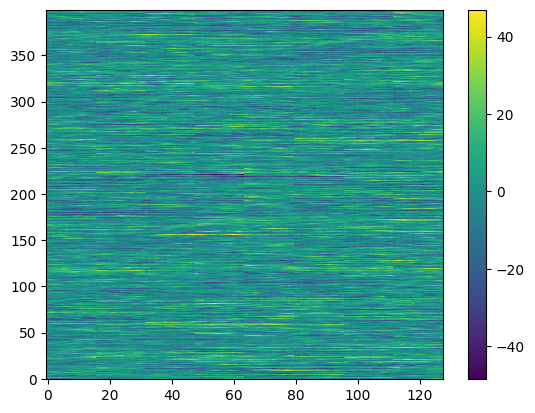

In [107]:
plt.imshow(temp[:,:].squeeze(), aspect='auto', origin='lower', interpolation='none')
plt.colorbar()
plt.show()


In [115]:
import numpy as np

# Set the seed for reproducibility
np.random.seed(42)

# Generate random numbers and use them to shuffle the array
array = np.arange(1, 11)  # Create an array [1, 2, ..., 10]
random_numbers = np.random.rand(len(array))
sort_idx = np.argsort(random_numbers)
shuffled_array = array[sort_idx]

print(shuffled_array)

[ 7  6  5  1  4  9 10  3  8  2]


In [96]:
temp.squeeze().shape

(128, 400)

In [16]:
import pop_loadset
import importlib
importlib.reload(pop_loadset)  # Step 3: Reload the library to reflect the changes
from pop_loadset import pop_loadset

var = pop_loadset('var.mat')
var['test'][2]

dict_keys(['__header__', '__version__', '__globals__', 'setname', 'filename', 'filepath', 'subject', 'group', 'condition', 'session', 'comments', 'nbchan', 'trials', 'pnts', 'srate', 'xmin', 'xmax', 'times', 'data', 'icaact', 'icawinv', 'icasphere', 'icaweights', 'icachansind', 'chanlocs', 'urchanlocs', 'chaninfo', 'ref', 'event', 'urevent', 'eventdescription', 'epoch', 'epochdescription', 'reject', 'stats', 'specdata', 'specicaact', 'splinefile', 'icasplinefile', 'dipfit', 'history', 'saved', 'etc', 'datfile', 'run', 'roi'])
dict_keys(['__header__', '__version__', '__globals__', 'setname', 'filename', 'filepath', 'subject', 'group', 'condition', 'session', 'comments', 'nbchan', 'trials', 'pnts', 'srate', 'xmin', 'xmax', 'times', 'data', 'icaact', 'icawinv', 'icasphere', 'icaweights', 'icachansind', 'chanlocs', 'urchanlocs', 'chaninfo', 'ref', 'event', 'urevent', 'eventdescription', 'epoch', 'epochdescription', 'reject', 'stats', 'specdata', 'specicaact', 'splinefile', 'icasplinefile',

/Users/arno/Python/iclabel/pop_loadset.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([new_check(item) for item in obj])


FileNotFoundError: [Errno 2] No such file or directory: 'var.mat'

In [71]:
import pop_loadset
import importlib
importlib.reload(pop_loadset)  # Step 3: Reload the library to reflect the changes
from pop_loadset import pop_loadset
import numpy as np
from scipy.signal import resample
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt



eeglab_file_path = './eeglab_data_with_ica_tmp.set'
EEG = pop_loadset(eeglab_file_path)


# convert EEG['event'] to list
EEG['event'] = EEG['event'].tolist()

# save EEG dictionary as a .mat file
import scipy.io
scipy.io.savemat('EEG2.mat', EEG)

EEG['event'][0]

# create np.dtype for the structured array EEG['event'] in a general way scanning all event fields
dtype = np.dtype([(key, 'O') for key in EEG['event'][0].keys()])





/Users/arno/Python/iclabel/pop_loadset.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([new_check(item) for item in obj])


AttributeError: 'dict' object has no attribute 'dtype'

In [36]:
from eeg_mne2eeglab import eeg_mne2eeglab

np.arange(0, 10, 2)

array([0, 2, 4, 6, 8])

In [30]:
import numpy as np
from scipy.signal import resample
#from numpy.fft import fft, ifft
from scipy.fft import fft, ifft
import random
import pop_loadset
import importlib
importlib.reload(pop_loadset)  # Step 3: Reload the library to reflect the changes
from pop_loadset import pop_loadset
import numpy as np
from scipy.signal import resample
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
import scipy.io

eeglab_file_path = './eeglab_data_with_ica_tmp.set'
#eeglab_file_path = '/System/Volumes/Data/data/matlab/eeglab/sample_data/eeglab_data_epochs_ica.set'
EEG = pop_loadset(eeglab_file_path)
#isinstance(EEG['chanlocs'][0], scipy.io.matlab._mio5_params.mat_struct)

# EEG = {
#     'srate': 256,
#     'icaweights': np.random.randn(10, 256),
#     'pnts': 1000,
#     'trials': 5,
#     'icaact': np.random.randn(10, 1000, 5)
# }
    
pct_data = None

#def eeg_autocorr_welch(EEG, pct_data=100):
if pct_data is None or pct_data == 0:
    # clean input cutoff freq
    if pct_data is None or pct_data == 0:
        pct_data = 100
    
    # setup constants
    ncomp = EEG['icaweights'].shape[0]
    n_points = min(EEG['pnts'], EEG['srate'] * 3)
    nfft = 2**(int(np.log2(n_points * 2 - 1)) + 1)
    cutoff = (EEG['pnts'] // n_points) * n_points
    index = np.add.outer(np.ceil(np.arange(0, cutoff - n_points, n_points // 2)).astype(int), np.arange(n_points)).astype(int)
    
    # separate data segments
    if pct_data != 100:
        random.seed(0)
        n_seg = index.shape[0] * EEG['trials']
        subset = random.sample(range(n_seg), int(np.ceil(n_seg * pct_data / 100)))
        random.seed()  # restore normal random behavior
        temp = np.reshape(EEG['icaact'][:, index, :], (ncomp, *index.shape, EEG['trials']))
        segments = temp[:, :, subset]
    else:
        segments = np.reshape(EEG['icaact'][:, index, :], (ncomp, *index.shape, EEG['trials']))
    
    # calc autocorrelation
    ac = np.zeros((ncomp, nfft))
    for it in range(ncomp):
        fftpow = np.mean(np.abs(fft(segments[it, :, :], nfft, axis=1))**2, axis=2)
        ac[it, :] = np.real(ifft(fftpow, axis=0))
    
    # normalize
    if EEG['pnts'] < EEG['srate']:
        ac = np.concatenate([ac[:, :EEG['pnts']] / (ac[:, 0][:, np.newaxis] * np.arange(n_points, 0, -1) / n_points), 
                             np.zeros((ncomp, EEG['srate'] - n_points + 1))], axis=1)
    else:
        ac = ac[:, :EEG['srate'] + 1] / (ac[:, 0][:, np.newaxis] * np.concatenate([np.arange(n_points, n_points - EEG['srate'], -1), 
                                                                                   [max(1, n_points - EEG['srate'])]] / n_points))
    
    # resample to 1 second at 100 samples/sec
    ac = resample(ac.T, 100, axis=0).T
    ac = ac[:, 1:101]
   
    # resample to 1 second at 100 samples/sec
    ac = resample(ac.T, 100, axis=0).T
    ac = ac[:, 1:101]
    
    #return ac

# Assuming EEG class or data structure is defined with appropriate fields
# Example usage:
# ac = eeg_autocorr_welch(EEG, pct_data=50)
    # print information about psdmed
   
    
    #assert psdmed.shape == (10, 100)
    #assert np.all(np.isfinite(psdmed))

#test_eeg_autocorr()

/Users/arno/Python/iclabel/pop_loadset.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([new_check(item) for item in obj])


ValueError: could not broadcast input array from shape (158,1024) into shape (1024,)

In [3]:
import numpy as np
from scipy.signal import resample_poly

# Generate random numbers between 69 and 251
ac = np.random.randint(69, 251, size=(251,))  # 251 samples as in MATLAB

# Resample to match MATLAB's behavior
resamp = resample_poly(ac, up=100, down=250)

# Get the size of the resampled array
size_resamp = resamp.shape[0]

print(size_resamp)  # Should be 101

101


In [21]:
import pop_loadset
import importlib
importlib.reload(pop_loadset)  # Step 3: Reload the library to reflect the changes
from pop_loadset import pop_loadset
import numpy as np
from scipy.signal import resample
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
import scipy.io

eeglab_file_path = './eeglab_data_with_ica_tmp.set'
#eeglab_file_path = '/System/Volumes/Data/data/matlab/eeglab/sample_data/eeglab_data_epochs_ica.set'
EEG = pop_loadset(eeglab_file_path)
#isinstance(EEG['chanlocs'][0], scipy.io.matlab._mio5_params.mat_struct)

EEG



Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/arno/miniconda3/envs/p311env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/3j/r_x6gj790wvcx_mh157ctypm0000gn/T/ipykernel_5325/460132573.py", line 13, in <module>
    EEG = pop_loadset(eeglab_file_path)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arno/Python/iclabel/pop_loadset.py", line 95, in pop_loadset
    EEG['icaact'] = np.dot(np.dot(EEG['icaweights'], EEG['icasphere']), EEG['data'].reshape(EEG['nbchan'], -1))
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<__array_function__ internals>", line 180, in dot
TypeError: unsupported operand type(s) for *: 'NoneType' and 'NoneType'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/arno/miniconda3/envs/p311env/lib/python3.11/site-packages/IPython/core/interactives

In [22]:
import numpy as np

cutoff = 375
n_points = 125
index = np.add.outer(np.arange(0, cutoff - n_points//2 + 1, n_points // 2), np.arange(0, n_points)).astype(int).transpose()
index
np.ceil(np.arange(0, cutoff - n_points + 1, n_points/2)).astype(int)
index = np.add.outer(np.ceil(np.arange(0, cutoff - n_points + 1, n_points/2)).astype(int), np.arange(0, n_points)).astype(int).transpose()
index



array([[  0,  63, 125, 188, 250],
       [  1,  64, 126, 189, 251],
       [  2,  65, 127, 190, 252],
       [  3,  66, 128, 191, 253],
       [  4,  67, 129, 192, 254],
       [  5,  68, 130, 193, 255],
       [  6,  69, 131, 194, 256],
       [  7,  70, 132, 195, 257],
       [  8,  71, 133, 196, 258],
       [  9,  72, 134, 197, 259],
       [ 10,  73, 135, 198, 260],
       [ 11,  74, 136, 199, 261],
       [ 12,  75, 137, 200, 262],
       [ 13,  76, 138, 201, 263],
       [ 14,  77, 139, 202, 264],
       [ 15,  78, 140, 203, 265],
       [ 16,  79, 141, 204, 266],
       [ 17,  80, 142, 205, 267],
       [ 18,  81, 143, 206, 268],
       [ 19,  82, 144, 207, 269],
       [ 20,  83, 145, 208, 270],
       [ 21,  84, 146, 209, 271],
       [ 22,  85, 147, 210, 272],
       [ 23,  86, 148, 211, 273],
       [ 24,  87, 149, 212, 274],
       [ 25,  88, 150, 213, 275],
       [ 26,  89, 151, 214, 276],
       [ 27,  90, 152, 215, 277],
       [ 28,  91, 153, 216, 278],
       [ 29,  

In [21]:
data = scipy.io.loadmat('python_temp.mat')
data['grid'][0][2]

ic_classes = EEG['etc']['ic_classification']\
    ['ICLabel']['classifications']

IndexError: index 3 is out of bounds for axis 0 with size 3

In [6]:
from pop_loadset import pop_loadset

# Create an in-memory bytes buffer
eeglab_file_path = './tmp2.set'
#eeglab_file_path = '/System/Volumes/Data/data/matlab/eeglab/sample_data/eeglab_data_epochs_ica.set'
EEG = pop_loadset(eeglab_file_path)

TypeError: 'float' object cannot be interpreted as an integer

In [1]:
import numpy as np

# Example initialization for features (mock data)
features = [
    np.random.rand(5, 5, 5, 5).astype(np.float32),  # Random 4D array
    np.random.rand(5, 5, 5, 1).astype(np.float32),  # Random 4D array
    np.random.rand(5, 5, 5, 1).astype(np.float32)   # Random 4D array
]

# Check initial shapes
print("Initial shapes:")
for i, feature in enumerate(features):
    print(f"features[{i}]:", feature.shape)

# Equivalent of MATLAB code for features[0]
features[0] = np.single(
    np.concatenate([
        features[0],                                   # Original array
        -features[0],                                  # Negated array
        features[0][:, ::-1, :, :],                    # Array with 2nd dimension reversed
        -features[0][:, ::-1, :, :]                    # Negated reversed array
    ], axis=3)                                         # Concatenate along the 4th dimension
)
print("features[0] shape after concatenation:", features[0].shape)

# Equivalent of MATLAB code for features[1]
features[1] = np.single(
    np.tile(features[1], (1, 1, 1, 4))                 # Replicate along 4th dimension
)
print("features[1] shape after tiling:", features[1].shape)

# Equivalent of MATLAB code for features[2]
features[2] = np.single(
    np.tile(features[2], (1, 1, 1, 4))                 # Replicate along 4th dimension
)
print("features[2] shape after tiling:", features[2].shape)

# Verify data types
for i, feature in enumerate(features):
    print(f"features[{i}] dtype:", feature.dtype)

Initial shapes:
features[0]: (5, 5, 5, 5)
features[1]: (5, 5, 5, 1)
features[2]: (5, 5, 5, 1)
features[0] shape after concatenation: (5, 5, 5, 20)
features[1] shape after tiling: (5, 5, 5, 4)
features[2] shape after tiling: (5, 5, 5, 4)
features[0] dtype: float32
features[1] dtype: float32
features[2] dtype: float32
